# Papagaio - MIDI generation using Bi-Directional LSTM

## Setup

##### Install, import and configure dependencies

In [ ]:
!pip install -q music21
!pip install -q fastprogress
# !pip install -q midi2audio
!pip install -q fluidsynth

In [ ]:
# Basic libraries
import random
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocessing data libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data visualization
from torch.utils.tensorboard import SummaryWriter

# Utils
import music21
from fastprogress.fastprogress import master_bar, progress_bar

# Playing files
# from midi2audio import FluidSynth


# Codification modules
from encoder import *
from decoder import *

# Environment setup
%matplotlib inline
# music21.configure.run()
import notebook

##### Set device

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

# DATASET

##### Separate Stackframe data from Info data 

In [ ]:

# TODO: receive a input int for the amount of info data (currently 4).
#       this way testing will be easier.

def getStackframe(data, first_frame, last_frame, to_float=True):
    stackframe = data.iloc[first_frame:last_frame, 4:]
    stackframe = stackframe.to_numpy()

    if to_float:
        stackframe.astype(float)
        stackframe = stackframe + 0.0

    return stackframe

def getInfo(data, first_frame, last_frame):
    infos = data.iloc[first_frame:last_frame, 0:4]
    return infos

##### Merge Stackframe and Info to match the codification

In [ ]:
def mergeData(infos, stackframe, instrument, midi_offset):

    # (A, B, C)
    #
    # A -> number of measures (bars)
    # B -> number of frames (resolution)
    # C -> number of notes (keyboard size)

    n_measures = stackframe.shape[0]
    resolution = stackframe.shape[1]
    keyboard_size = stackframe.shape[2]

    # Generate note names and use as column
    sf_columns = [key_index2note(i, midi_offset).nameWithOctave for i in range(keyboard_size)]
    
    # Initialize blank df with notes column
    measures = pd.DataFrame([], columns=sf_columns)
    measures.index.name = 'inst'
    
    # 
    for i in range(n_measures):
        indexes = pd.Series([instrument for i in range(resolution)])
        decoded_measure = pd.DataFrame(stackframe[i], columns=sf_columns).set_index(pd.Index(indexes)) 
        measures = measures.append(decoded_measure) 

    print(f'Info shape {infos.shape} | measures shape {measures.shape}')
    
    output = pd.concat([infos, measures], axis=1)

    print(f'Result shape {output.shape}')

    return output

# Reshape so that we have all frames in one dimension
# generated_sf = generated_sf.reshape(-1, generated_sf.shape[-1])
# print(f'Reshaped stackframe: \n {generated_sf} \t Shape: {generated_sf.shape}')


##### Read all dataset and isolates the data from a single instrument

In [ ]:
def createInstrumentDataset(datasetPath, instrument, n_frames):
    instrumentDataset = []
    for filename in os.listdir(datasetPath):
        if filename.endswith('pkl'):
            infile = open(datasetPath + filename,'rb')
            encoded_df = pickle.load(infile)
            
            infile.close()

            instrument_df = encoded_df[encoded_df.index==instrument]
            
            first_frame = 0
            last_frame = len(instrument_df)

            stackframe = getStackframe(instrument_df, first_frame=first_frame, last_frame=last_frame)
            instrumentDataset.append(np.array(stackframe))
      
    return instrumentDataset

##### Split dataset into two blocks, one frame apart at every single index

In [ ]:
def splitDataset(dataset, n_frames):
    X = []
    y = []
    
    # create two arrays X, y with bars
    for song in dataset:
        # create the frame blocks shifted in one position
        for i in range(song.shape[0] - n_frames):
            j = i + n_frames
            xa = song[i:j]
            ya = song[i+1:j+1]
            X.append(xa)
            y.append(ya)
        
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='float64')
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    
    training_ds = TensorDataset(X, y) # (X, y)
    return training_ds

# MODEL

##### Define model class with heritage of PyTorch's Module

In [ ]:
class BI_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(BI_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional=True)
    self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
    self.fc2 = nn.Linear(hidden_size*2, output_size)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus(beta=500, threshold=0)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, hidden, cell):
    # Passing in the input and hidden state into the model and obtaining outputs
    out, (hidden, cell) = self.lstm(x.unsqueeze(1), (hidden, cell))

    # Reshaping the outputs such that it can be fit into the fully connected layer
    out = out.contiguous().view(-1, self.hidden_size*2)

    out = self.fc2(out)
    out = self.sigmoid(out)
    
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    # This method generates the first hidden state of zeros which we'll use in the forward pass
    # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    
    return hidden, cell

In [ ]:
def plot_loss_update(epoch, epochs, mb, train_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = train_loss
    graphs = [[x,train_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

##### Training loop

In [ ]:
def train(model, optimizer, loss_fn, dataloader, batch_size=1, num_epochs=50):
    writer = SummaryWriter()

    print("[Train Starting]")

    s_time = time.time()

    mb = master_bar(range(1, num_epochs+1))
    mb.names = ['Loss', 'FrameBlock']
    train_loss = []


    for epoch_index in mb:
        count = 0
        training_loss = 0.0

        n_frameblocks = len(dataloader.dataset.tensors[0])

        input, target = getSample(dataloader)
        input = input.to(device)
        target = target.to(device)
        
        # Initialize hidden and cells
        hidden, cell = model.init_hidden(batch_size)

        for frameblock_index in progress_bar(range(n_frameblocks), parent=mb):

            # Generate predictions
            frameblock = input[frameblock_index,:]
            output, (hidden, cell) = model(frameblock, hidden, cell)
            

            # Compute the loss and backpropag
            loss_step = loss_fn(output, target[frameblock_index, :])

            hidden = hidden.detach()
            cell = cell.detach()

            count += 1

            loss_step.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            optimizer.zero_grad() # Clears existing gradients from previous frame

            training_loss += loss_step.item()

            mb.child.comment = f'[Loss {training_loss:.8f}]'

        training_loss /= len(dataloader.dataset)
        writer.add_scalar("Loss/train", training_loss, epoch_index)

        train_loss.append(training_loss)
        mb.main_bar.comment = f'[Epoch {epoch_index} | Loss {training_loss:.8f}]'
        plot_loss_update(epoch_index, num_epochs, mb, train_loss)

    writer.flush()
    writer.close()

    print(f'[Finished training with Loss {training_loss:.8f} (took {time.time() - s_time} seconds)]')

##### Given the model and some context data, generate a certain amount of measures (default: 1)

In [ ]:
# TODO: Be able to especify the number of measures to predict!

@torch.no_grad()
def generateMeasures(model, context, n_frames, amount=1, temperature=0.5, batch_size=1):
    hidden, cell = model.init_hidden(batch_size)

    if isinstance(context, torch.Tensor):
      # send to gpu
      context_frameblocks = context.cuda()
      # cast to float
      context_frameblocks = context_frameblocks.float()
    else:
      context_frameblocks = torch.from_numpy(context.astype(float)).float().to(device)

    # amount of frameblocks in the context input
    context_fb_n = len(context_frameblocks) - n_frames

    # getting context iterating over
    # N-1 of the frameblocks

    for i in range(context_fb_n):
        context_fb = context_frameblocks[i:i + n_frames]

        # we dont care about the output here.
        # we are just feeding the model with the
        # context we received as input
        _, (hidden, cell) = model(context_fb,
                                  hidden, cell)

    # we must get the output from the last context fb
    last_fb = context_frameblocks[context_fb_n:]

    output_measures = []
    for _ in range(amount):
      
      out, (hidden, cell) = model(last_fb, hidden, cell)
      
      # generate the other remaining frames
      for i in range(n_frames- 1):
        out = torch.where(out >= (1-temperature), 1, 0).float()
        out, (hidden, cell) = model(out, hidden, cell)

        # update last frame block
        last_fb = out


      out = np.where(out.cpu() >= (1-temperature), True, False)
      output_measures.append(out)

    # print(out, out.shape)
    return np.array(output_measures, dtype=bool)

##### Instanciate with desired parameters

In [ ]:

RESOLUTION = 36 # Frame per measure amount

MIDI_OFFSET = 20 # MIDI index for the first Model's Keyboard key

KEYBOARD_SIZE = 88 # Amount of keys in the Model's Keyboard

NUM_LAYERS = 4

# Instantiate the model with hyperparameters
# We'll also set the model to the device that we defined earlier
model = BI_LSTM(input_size=KEYBOARD_SIZE,
                output_size=KEYBOARD_SIZE,
                hidden_size=RESOLUTION,
                num_layers=NUM_LAYERS).to(device)

# TRAIN MODEL

##### Set training options

In [ ]:
lr = 3e-4 # Learning Rate
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss() # Binary Cross Entropy

MODELS_PATH = '../models/'
MODEL_NAME = 'BI_LSTM'

N_EPOCHS = 15 # Number of times that the model will go trough all the 

##### Retrieve a sample of data from Dataloader

In [ ]:
def getSample(dataloader):

  n_frameblocks = len(dataloader.dataset.tensors[0])

  input = torch.zeros(n_frameblocks, RESOLUTION, KEYBOARD_SIZE)
  target = torch.zeros(n_frameblocks, RESOLUTION, KEYBOARD_SIZE)

  for sample, (xb, yb) in enumerate(dataloader): # gets the samples
    input[sample] = xb
    target[sample] = yb
  
  return input, target

##### Let's create a dataset for a given instrument, in this case I'll choose piano

In [ ]:
datasetName = 'test'

datasetPath = f'../datasets/codification/{datasetName}/'
modelsPath  = '../models/{datasetName}/'

INSTRUMENT = 'Alto saxophone'

instrumentDataset = createInstrumentDataset(datasetPath, INSTRUMENT, RESOLUTION)
print(f'Dataset {datasetName}, Instrument {INSTRUMENT}, Instrument Dataset size {len(instrumentDataset)}')

Dataset test, Instrument Alto saxophone, Instrument Dataset size 30


##### Prepare training Dataset and Dataloader

In [ ]:
training_ds = splitDataset(instrumentDataset, RESOLUTION)
training_dl = DataLoader(training_ds, batch_size=1, shuffle=False)

print(f'Training DataLoader length:\t{len(training_dl.dataset.tensors[0])}')

Training DataLoader length:	12852


### Run train

[Train Starting]


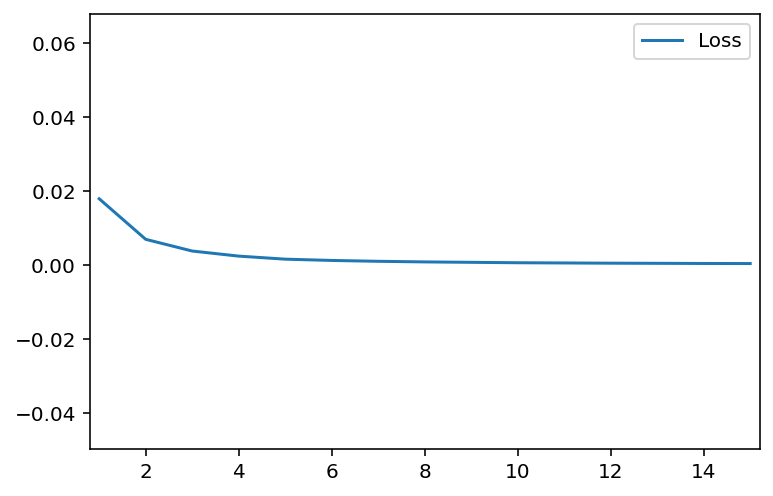

[Finished training with Loss 0.00033251 (took 2529.1273045539856 seconds)]


In [ ]:
SAVE_AS = f'{MODELS_PATH}{MODEL_NAME}_{INSTRUMENT}_[{N_EPOCHS}].pt' # Name of the output LSTM data

#!jupyter nbextension enable --py widgetsnbextension
train(model, optimizer, loss_fn, training_dl, num_epochs=N_EPOCHS)

torch.save(model, SAVE_AS)

# GENERATE
##### Prepare context data representation

In [ ]:
# Read context file
CONTEXT = pd.read_pickle(datasetPath + 'We Are Family (Single Version).pkl')

# Filter by instrument
CONTEXT = CONTEXT[CONTEXT.index==INSTRUMENT]

# If the file does not contain the instrument
if len(CONTEXT) == 0:
    raise ValueError(f'Oops, it seems that the selected context file does not contain this instrument ({INSTRUMENT}).')

print(f'{INSTRUMENT} context data shape {CONTEXT.shape}')
print(f'{INSTRUMENT} context measures {CONTEXT.shape[0] / RESOLUTION}')

Alto saxophone context data shape (7488, 92)
Alto saxophone context measures 208.0


##### Set generation parameters

In [ ]:
CONTEXT_FIRST_MEASURE = 25
CONTEXT_AMOUNT = 30 # Amount of measures of context
GENERATE_AMOUNT = 30 # Amount of measures to generate
TEMPERATURE = 0.7 # Predicted probability must be >= 80% to note be played

# INFO_SIZE = 4

first_context_frame = (CONTEXT_FIRST_MEASURE-1)*RESOLUTION
last_context_frame = first_context_frame + RESOLUTION*CONTEXT_AMOUNT

first_generated_frame = last_context_frame
last_generated_frame = first_generated_frame + RESOLUTION*GENERATE_AMOUNT

context_info = getInfo(CONTEXT, first_context_frame, last_context_frame)
context_sf = getStackframe(CONTEXT, first_context_frame, last_context_frame, to_float=True)

generated_info = getInfo(CONTEXT, first_generated_frame, last_generated_frame)

print(f'CONTEXT_INFO: \n {context_info} \n\n')
print(f'CONTEXT_SF: \n {context_sf} \t Shape: {context_sf.shape}')

print(f'GENERATED_INFO: \n {generated_info}')

CONTEXT_INFO: 
                inst_code ks     bpm   ts
inst                                    
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
...                  ... ..     ...  ...
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4

[1080 rows x 4 columns] 


CONTEXT_SF: 
 [[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]] 	 Shape: (1080, 88)
GENERATED_INFO: 
                inst_code ks     bpm   ts
inst                                    
Alto saxophone        65  d  118.02  4/4
Alto saxophone        65  d  118.02  4/4
Alto saxophone 

##### Let's see the context we'll feed the model

Decoding instrument: Alto saxophone


Took 26.459986925125122


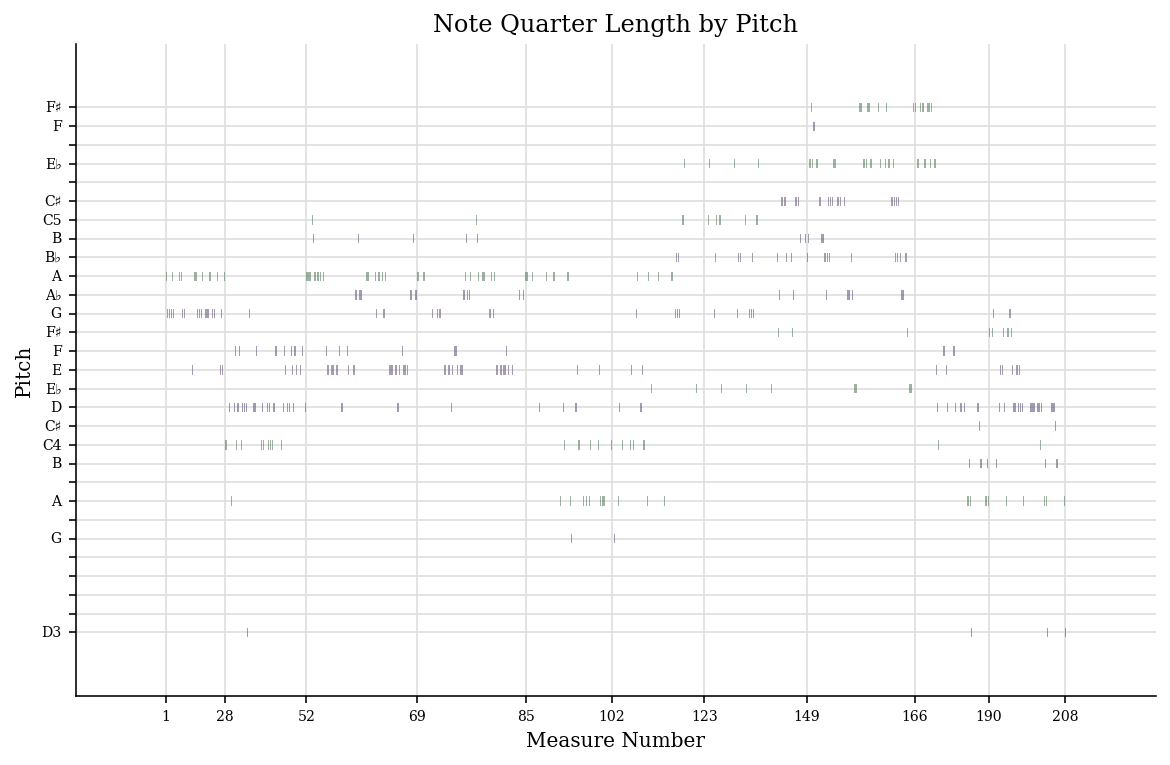

In [ ]:
decode_data(CONTEXT, RESOLUTION).plot()

##### Generate measures stackframes

In [ ]:
start_timer = time.time()
generated_sf = generateMeasures(model,
                                context_sf,
                                RESOLUTION,
                                amount=GENERATE_AMOUNT,
                                temperature=TEMPERATURE
                                )
end_timer = time.time()
print(f'GENERATED STACKFRAMES: \n {generated_sf} \t Shape: {generated_sf.shape}')
print(f'Generated {generated_sf.shape[0]} measures in {end_timer - start_timer} seconds')

GENERATED STACKFRAMES: 
 [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False 

##### Merge Info and StackFrame to get the complete, decodable representation

In [ ]:
# Merge StackFrame and Info blocks
generated_representation = mergeData(generated_info, generated_sf, INSTRUMENT, MIDI_OFFSET)

print(f'Generated representation: \n {generated_representation.to_string()}')

Info shape (1080, 4) | measures shape (1080, 88)
Result shape (1080, 92)


Generated representation: 
                inst_code ks     bpm   ts    G#0     A0    B-0     B0     C1    C#1     D1    E-1     E1     F1    F#1     G1    G#1     A1    B-1     B1     C2    C#2     D2    E-2     E2     F2    F#2     G2    G#2     A2    B-2     B2     C3    C#3     D3    E-3     E3     F3    F#3     G3    G#3     A3    B-3     B3     C4    C#4     D4    E-4     E4     F4    F#4     G4    G#4     A4    B-4     B4     C5    C#5     D5    E-5     E5     F5    F#5     G5    G#5     A5    B-5     B5     C6    C#6     D6    E-6     E6     F6    F#6     G6    G#6     A6    B-6     B6     C7    C#7     D7    E-7     E7     F7    F#7     G7    G#7     A7    B-7     B7
inst                                                                                                                                                                                                                                                                                                                       

##### Send generated representation to the decoder module and plot result

Decoding instrument: Alto saxophone


Took 2.9989383220672607


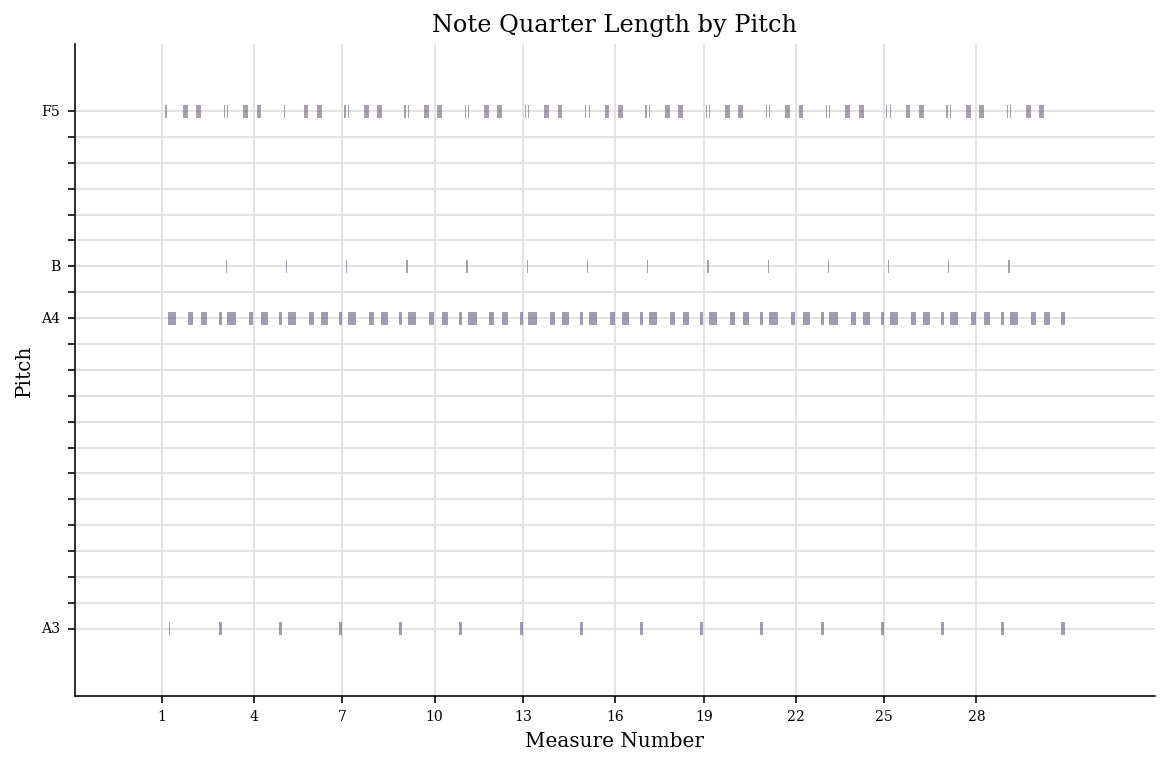

In [ ]:
OUTPUT_PATH = '../results/test'

# Send representation to decoder
generated = decode_data(generated_representation, RESOLUTION, save_as=OUTPUT_PATH)

generated.plot()

# HEARING GENERATED
##### Now we can play the generated midi file

In [ ]:
synth = FluidSynth()
synth.midi_to_audio(OUTPUT_PATH+'.mid', OUTPUT_PATH+'.mid'+'.wav')
synth.play_midi()

FileNotFoundError: [Errno 2] No such file or directory: 'fluidsynth'